In [17]:
from math import log, sqrt, exp
from scipy import stats

#present value of european option
def bsm_call_value(s0, K, T, r, sigma):
    '''s0 = initial indexlevel
        K = strike price
        T = maturity rate in fraction of years
        r = risk free short rate
        sigma = volitlity factor
    '''
    s0 = float(s0)
    d1 = (log(s0/K)+(r+0.5 * sigma**2)*T)/(sigma* sqrt(T))
    d2 = (log(s0/K)+(r-0.5 * sigma**2)*T)/(sigma* sqrt(T))
    value = (s0 * stats.norm.cdf(d1, 0.0,1.0) - K * exp(-r*T) * stats.norm.cdf(d2,0.0,1.0))
    return value

#vega of european option
def bsm_vega(s0, K, T, r, sigma):
    '''s0 = initial indexlevel
        K = strike price
        T = maturity rate in fraction of years
        r = risk free short rate
        sigma = volitlity factor
    '''
    s0 = float(s0)
    d1 = (log(s0/K)+(r+0.5 * sigma**2)*T)/(sigma* sqrt(T))
    vega = s0 * stats.norm.cdf(d1, 0.0, 1.0) * sqrt(T)
    return vega

#estimated volitility of european option
def bsm_call_imp_vol(s0, K, T, r, C0, sigma_est, it=100):
    '''s0 = initial indexlevel
        K = strike price
        T = maturity rate in fraction of years
        r = risk free short rate
        sigma_est = esitimated volitlity factor
        it = number of iterations
    '''
    for i in range(it):
        sigma_est -= ((bsm_call_value(s0, K, T, r, sigma_est)- C0) / bsm_vega(s0, K,T,r,sigma_est))
    return sigma_est

In [9]:
V0 = 17.6639

In [10]:
r = 0.01

In [13]:
import pandas as pd
h5 = pd.HDFStore('./source/vstoxx_data_31032014.h5', 'r')
futures_data = h5['futures_data']
options_data = h5['options_data']
h5.close()

In [14]:
futures_data

,DATE,EXP_YEAR,EXP_MONTH,PRICE,MATURITY,TTM
496,2014-03-31,2014,4,17.85,2014-04-18,0.049
497,2014-03-31,2014,5,19.55,2014-05-16,0.126
498,2014-03-31,2014,6,19.95,2014-06-20,0.222
499,2014-03-31,2014,7,20.40,2014-07-18,0.299
500,2014-03-31,2014,8,20.70,2014-08-15,0.375
501,2014-03-31,2014,9,20.95,2014-09-19,0.471
502,2014-03-31,2014,10,21.05,2014-10-17,0.548
503,2014-03-31,2014,11,21.25,2014-11-21,0.644


In [15]:
options_data['IMP_VOL'] = 0.0

In [22]:
tol = 0.5
for option in options_data.index:
    forward = futures_data[futures_data['MATURITY'] == options_data.loc[option]['MATURITY']]['PRICE'].values[0]
    if(forward * (1- tol) < options_data.loc[option]['STRIKE'] < forward * (1+tol)):
        imp_vol = bsm_call_imp_vol(V0,
                                   options_data.loc[option]['STRIKE'],
                                   options_data.loc[option]['TTM'],
                                   r,
                                   options_data.loc[option]['PRICE'],
                                   sigma_est=2.,it=100)
        options_data.loc[option, 'IMP_VOL'] = imp_vol

In [23]:
futures_data['MATURITY']

496   2014-04-18
497   2014-05-16
498   2014-06-20
499   2014-07-18
500   2014-08-15
501   2014-09-19
502   2014-10-17
503   2014-11-21
Name: MATURITY, dtype: datetime64[ns]

In [24]:
options_data.loc[46170]

DATE         2014-03-31 00:00:00
EXP_YEAR                    2014
EXP_MONTH                      4
TYPE                           C
STRIKE                       1.0
PRICE                      16.85
MATURITY     2014-04-18 00:00:00
TTM                        0.049
IMP_VOL                      0.0
Name: 46170, dtype: object

In [25]:
options_data.loc[46170]['STRIKE']

1.0

In [27]:
plot_data = options_data[options_data['IMP_VOL']>0]

In [29]:
maturities = sorted(set(options_data['MATURITY']))
maturities

[Timestamp('2014-04-18 00:00:00'),
 Timestamp('2014-05-16 00:00:00'),
 Timestamp('2014-06-20 00:00:00'),
 Timestamp('2014-07-18 00:00:00'),
 Timestamp('2014-08-15 00:00:00'),
 Timestamp('2014-09-19 00:00:00'),
 Timestamp('2014-10-17 00:00:00'),
 Timestamp('2014-11-21 00:00:00')]

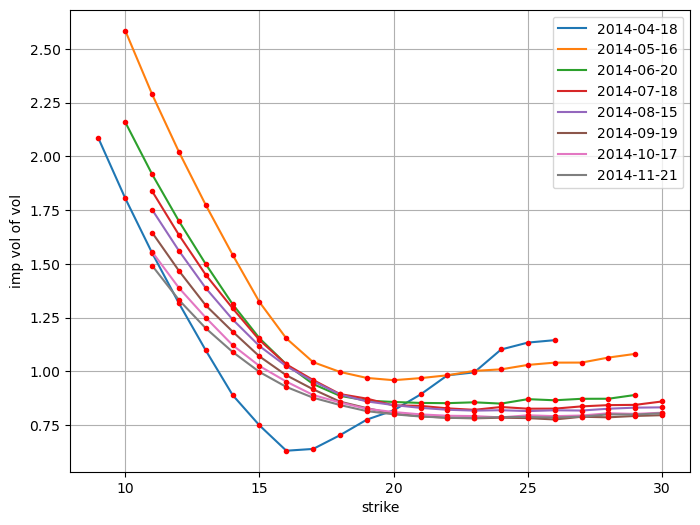

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8,6))
for maturity in maturities:
    data = plot_data[plot_data['MATURITY'] == maturity]
    plt.plot(data['STRIKE'],data['IMP_VOL'], label = maturity.date(), lw=1.5)
    plt.plot(data['STRIKE'],data['IMP_VOL'], 'r.')
plt.grid(True)
plt.xlabel('strike')
plt.ylabel('imp vol of vol')
plt.legend()
plt.show()

In [35]:
keep = ['PRICE', 'IMP_VOL']
group_data = plot_data.groupby(['MATURITY', 'STRIKE'])[keep]
group_data

In [ ]:
group_data = group_data.sum()
group_data.head()